In [ ]:
import pandas as pd
import numpy as np
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import torch
from torch.utils.data import Dataset, DataLoader
import torch.optim as torch_optim
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models

In [ ]:
if torch.cuda.is_available():
  print(torch.cuda.device_count())            # Numero di GPU disponibili
  print(torch.cuda.get_device_name(0))        # Nome della prima GPU disponibile
  print(torch.cuda.current_device())        # Device in uso al momento
  print(torch.cuda.set_device(0))             # Imposta la prima GPU come default
  print(torch.cuda.get_device_capability(0))  # Verifica le capacità della prima GPU

1
Tesla T4
0
None
(7, 5)


### ***DATASET & PRE-ELABORAZIONE***

In [ ]:
# Carico il dataset dal drive
path = './drive/MyDrive/Materiale_Pellegrino_personal/CTU_Shuffled/CTU_Shuffled.csv'
dataset = pd.read_csv(path)

In [ ]:
# Caratteristica temporale inutile 
dataset = dataset.drop('StartTime', axis=1)

In [ ]:
dataset

,Dur,Proto,Dir,State,sTos,dTos,TotPkts,TotBytes,SrcBytes,Details,multilabel
0,0.000540,1,<->,CON,0.0,0.0,2,131,71,flow=Background-UDP-Established,normal
1,0.014909,2,->,SRPA_FSPA,0.0,0.0,11,2882,1504,flow=Background-TCP-Established,normal
2,0.000798,1,<->,CON,0.0,0.0,2,244,182,flow=Background-UDP-Established,normal
3,15.302759,1,->,INT,0.0,NaN,4,336,336,flow=Background-UDP-Attempt,normal
4,7.843942,2,->,FSPA_SRPA,0.0,0.0,93,11846,4562,flow=Background-TCP-Established,normal
...,...,...,...,...,...,...,...,...,...,...,...
31468,8.917003,2,->,S_SA,0.0,0.0,8,512,194,flow=Background-TCP-Established,normal
31469,0.038780,1,<->,CON,0.0,0.0,2,191,68,flow=To-Background-UDP-CVUT-DNS-Server,normal
31470,603.106201,1,->,INT,0.0,NaN,6,552,552,flow=Background-Attempt-cmpgw-CVUT,normal
31471,0.000550,1,<->,CON,0.0,0.0,2,128,60,flow=Background-UDP-Established,normal


In [ ]:
print(Counter(dataset['multilabel']))

Counter({'normal': 31406, 'BotNet': 67})


In [ ]:
dep_var = 'multilabel'

cont_names = [col for col in dataset.columns if col != dep_var]

print(cont_names, 'len: ', len(cont_names))

['Dur', 'Proto', 'Dir', 'State', 'sTos', 'dTos', 'TotPkts', 'TotBytes', 'SrcBytes', 'Details'] len:  10


In [ ]:
# LabelEncoding della variabile target 
target_index = dataset.columns.get_loc(dep_var)
dataset.iloc[:, target_index] = LabelEncoder().fit_transform(dataset[dep_var])

#LabelEncoding delle variabili categoriali
for col in ["Dir", "State", "Details"]:
  target_index = dataset.columns.get_loc(col)
  dataset.iloc[:, target_index] = LabelEncoder().fit_transform(dataset[col])

# Fill NaN
""" Eliminiamo dalle colonne i valori nan """ 
for col in dataset.columns:
  dataset[col] = dataset[col].fillna(0)


In [ ]:
dataset.head()

,Dur,Proto,Dir,State,sTos,dTos,TotPkts,TotBytes,SrcBytes,Details,multilabel
0,0.000540,1,3,4,0.0,0.0,2,131,71,6,1
1,0.014909,2,0,89,0.0,0.0,11,2882,1504,4,1
2,0.000798,1,3,4,0.0,0.0,2,244,182,6,1
3,15.302759,1,0,53,0.0,0.0,4,336,336,5,1
4,7.843942,2,0,43,0.0,0.0,93,11846,4562,4,1


In [ ]:
from sklearn.model_selection import train_test_split

# train 50% e test 50%
train, test = train_test_split(dataset, test_size=0.50)

In [ ]:
y_train = train[dep_var]
train = train.drop(dep_var, axis=1)
y_test = test[dep_var]
test = test.drop(dep_var, axis=1)

# validation di 2500 righe da train
train, validation, y_train, y_val = train_test_split(train, y_train, test_size=(2500/len(train)), random_state=0)

In [ ]:
"""Visto che nel dataset la variabile target è molto squilibrata lo amplio con una generazione
 randomica di dati mediante la tecnica chiamata Synthetic Minority Over-sampling Technique (SMOTE)"""
 
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=0)
x_sm, y_train = sm.fit_resample(train, y_train)
train = pd.DataFrame(x_sm,columns=train.columns)

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
#y_train = y_train.values
y_test = y_test.values
y_val = y_val.values

In [ ]:
test

,Dur,Proto,Dir,State,sTos,dTos,TotPkts,TotBytes,SrcBytes,Details
30212,316.277405,2,0,79,0.0,0.0,32,2880,1238,2
3445,1.860478,1,3,4,0.0,0.0,26,20385,20013,6
19724,0.000267,1,3,4,0.0,0.0,2,214,70,46
10197,0.000260,1,3,4,0.0,0.0,2,214,81,46
9543,0.000329,1,3,4,0.0,0.0,2,214,81,46
...,...,...,...,...,...,...,...,...,...,...
11155,0.583620,3,0,67,0.0,0.0,2,140,140,42
29942,0.000365,1,3,4,0.0,0.0,2,372,87,46
13993,0.000265,1,3,4,0.0,0.0,2,214,81,46
24409,0.000317,1,3,4,0.0,0.0,2,214,81,46


In [ ]:
train

,Dur,Proto,Dir,State,sTos,dTos,TotPkts,TotBytes,SrcBytes,Details
0,0.000295,1.0,3.000000,4.000000,0.0,0.0,2.000000,409.000000,85.000000,46.000000
1,0.002029,1.0,3.000000,4.000000,0.0,0.0,2.000000,550.000000,490.000000,6.000000
2,0.000755,1.0,3.000000,4.000000,0.0,0.0,2.000000,137.000000,77.000000,6.000000
3,0.000361,1.0,3.000000,4.000000,0.0,0.0,2.000000,314.000000,85.000000,46.000000
4,0.000223,1.0,3.000000,4.000000,0.0,0.0,2.000000,214.000000,81.000000,46.000000
...,...,...,...,...,...,...,...,...,...,...
26403,58.621110,2.0,0.000000,87.277184,0.0,0.0,8.171739,1993.572960,832.865276,27.085869
26404,4.308502,2.0,0.000000,37.000000,0.0,0.0,10.955859,962.162899,520.162899,28.000000
26405,133.266316,2.0,1.505258,58.508004,0.0,0.0,32.065845,22105.731709,4268.825780,16.839507
26406,15.127515,2.0,0.763596,21.749171,0.0,0.0,2.654828,1503.361819,1360.100978,6.382909


In [ ]:
validation

,Dur,Proto,Dir,State,sTos,dTos,TotPkts,TotBytes,SrcBytes,Details
17177,0.000324,1,3,4,0.0,0.0,2,328,85,46
26319,304.167114,1,3,4,0.0,0.0,10,670,370,6
10767,0.004151,1,3,4,0.0,0.0,2,240,73,46
22412,0.000152,1,3,4,0.0,0.0,2,214,81,46
21934,0.000342,1,3,4,0.0,0.0,2,284,77,46
...,...,...,...,...,...,...,...,...,...,...
25712,483.011200,1,3,4,0.0,0.0,10,4190,666,6
2375,0.003502,2,0,37,0.0,0.0,9,1908,1049,2
23265,0.003895,1,3,4,0.0,0.0,4,2989,60,6
15918,0.000307,1,3,4,0.0,0.0,2,214,81,46


### ***GPU/CPU***

In [ ]:
""" Making device (GPU/CPU) compatible

(borrowed from https://jovian.ml/aakashns/04-feedforward-nn)

In order to make use of a GPU if available, we'll have to move our data and model to it. """ 

def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

device = get_default_device()
device

device(type='cuda')

### ***MODEL***

In [ ]:
""" Ghost Batch Normalization (GBN):
 Questa tenica ci consente di operare su grandi batch di dati e al tempo stesso ottenere buone generalizzazioni.
 In pratica: viene diviso il batch di in input in sotto-batch di dimensioni uguali (dimensione del batch 
 virtuale) e viene applicato lo stesso livello di Batch Normalization. 
 Tutti i layer di normalizzazione del modello, eccetto il primo, adottano questa tecnica. """

class GBN(nn.Module):
  def __init__(self,inp,vbs=128,momentum=1.0):
        super().__init__()
        self.bn = nn.BatchNorm1d(inp,momentum=momentum)
        self.vbs = vbs
        
  def forward(self,x):
        chunk = torch.chunk(x,x.size(0)//self.vbs,0)
        res = [self.bn(y) for y in chunk]
        return torch.cat(res,0)

""" SparseMax: 
  essa è una funzione di normalizzazione lineare come Softmax ma con una distribuzione più sparsa.
  Ovvero rispetto a Softmax alcuni numeri nella distribuzione della probabilità di output sono molto vicini
  a 1 mentre altri molto più vicini a 0; ciò consente al modello di selezionare le caratteristiche rilevanti in 
  ogni fase deciionale in modo più efficace. 
  Useremo Sparsemax per progettare la maschera per il passaggio di selezione delle features su uno spazio più ristretto. """

!pip install -U sparsemax

from sparsemax import Sparsemax

""" Attention Transformer: 
  è la fase in cui modelli apprendono la relazione tra le caratteristiche rilevanti e decidono quali trasferire al Feature Transformer.
  Ciascun Attention Transformer è costituito da: 
    - un livello completamente connesso;
    - un livello di GBN;
    - un livello Sparsemax.
  L'attention transformer in ogni fase decisionale riceve le caratteristiche di input, quelle elaborate nella fase precedente e le informazioni preliminari
  sulle caratteristiche utilizzate. 
  Tutte queste info sono rappresentate da una matrice di dim batch_size x input_features. Essa viene aggiornata in ogni fase decisionale.
  Esiste anche un parametro di "rilassamento" che limita il numero di volte in cui una determinata funzione può essere utilizzata in un passaggio in avanti. """

class AttentionTransformer(nn.Module):

    def __init__(self,d_a,inp_dim,relax,vbs=128):
        super().__init__()
        self.fc = nn.Linear(d_a,inp_dim)
        #self.bn = GBN(out_dim,vbs=vbs)
        self.bn = GBN(inp_dim, vbs=vbs)
        self.smax = Sparsemax()
        self.r = relax
    
    #a:feature from previous decision step
    
    def forward(self,a,priors): 
        a = self.bn(self.fc(a)) 
        mask = self.smax(a*priors) 
        priors =priors*(self.r-mask)  #updating the prior
        return mask

""" Feautre Transformer: 
 Il trasformatore di caratteristiche è dove tutte le caratteristiche selezionate vengono elaborate per generare l'output finale. 
 
 Ogni trasformatore di caratteristiche è composto da più Gated Linear Unit Blocks.
 Una GLU controlla quali informazioni devono essere autorizzate a fluire ulteriormente attraverso la rete. 
 Per implementare un blocco GLU, prima raddoppiamo la dimensione delle caratteristiche di input alla GLU utilizzando uno strato completamente connesso.
 Normalizziamo la matrice risultante utilizzando un GBN Layer. Quindi, applichiamo un sigmoide alla seconda metà delle caratteristiche risultanti 
 e moltiplichiamo i risultati per la prima metà. Il risultato viene moltiplicato per un fattore di scala (sqrt (0,5) in questo caso) e aggiunto all'input. 
 Questo risultato sommato è l'input per il blocco GLU successivo nella sequenza.

 Un certo numero di blocchi GLU è condiviso tra tutte le fasi decisionali per promuovere la capacità e l'efficienza del modello (opzionale). 
 Il primo blocco GLU condiviso (o il primo blocco indipendente se non ci sono blocchi condivisi) è unico in quanto riduce la dimensione 
 delle features di input ad una dimensione uguale n_a + n_d. 
 n_a è la dimensione delle caratteristiche in ingresso al trasformatore di attenzione del passaggio successivo e 
 n_d è la dimensione delle caratteristiche utilizzate per calcolare i risultati finali. 
 Queste caratteristiche vengono elaborate insieme fino a raggiungere lo splitter. 
 L'attivazione di ReLU viene applicata al vettore dimensionato n_d. 
 Gli output di tutte le fasi decisionali vengono sommati e passati attraverso un livello completamente connesso per mapparli alla dimensione di output. """

class GLU(nn.Module):

  def __init__(self,inp_dim,out_dim,fc=None,vbs=128):
      super().__init__()
      if fc:
          self.fc = fc
      else:
          self.fc = nn.Linear(inp_dim,out_dim*2)
      self.bn = GBN(out_dim*2,vbs=vbs) 
      self.od = out_dim

  def forward(self,x):
      x = self.bn(self.fc(x))
      return x[:,:self.od]*torch.sigmoid(x[:,self.od:])

class FeatureTransformer(nn.Module):

  def __init__(self,inp_dim,out_dim,shared,n_ind,vbs=128):
      super().__init__()
      first = True
      self.shared = nn.ModuleList()
      if shared:
          self.shared.append(GLU(inp_dim,out_dim,shared[0],vbs=vbs))
          first= False    
          for fc in shared[1:]:
              self.shared.append(GLU(out_dim,out_dim,fc,vbs=vbs))
      else:
          self.shared = None
      self.independ = nn.ModuleList()
      if first:
          self.independ.append(GLU(inp,out_dim,vbs=vbs))
      for x in range(first, n_ind):
          self.independ.append(GLU(out_dim,out_dim,vbs=vbs))
      self.scale = torch.sqrt(torch.tensor([.5],device=device))

  def forward(self,x):
      if self.shared:
          x = self.shared[0](x)
          for glu in self.shared[1:]:
              x = torch.add(x, glu(x))
              x = x*self.scale
      for glu in self.independ:
          x = torch.add(x, glu(x))
          x = x*self.scale
      return x
      
""" Combiniamo Attention Transformer e Feature Transformer in un DecisionStep """

class DecisionStep(nn.Module):
  
    def __init__(self,inp_dim,n_d,n_a,shared,n_ind,relax,vbs=128):
        super().__init__()
        self.fea_tran = FeatureTransformer(inp_dim,n_d+n_a,shared,n_ind,vbs)
        self.atten_tran =  AttentionTransformer(n_a,inp_dim,relax,vbs)
    
    def forward(self,x,a,priors):
        mask = self.atten_tran(a,priors)
        sparse_loss = ((-1)*mask*torch.log(mask+1e-10)).mean()
        x = self.fea_tran(x*mask)
        return x,sparse_loss

Requirement already up-to-date: sparsemax in /usr/local/lib/python3.7/dist-packages (0.1.9)


In [ ]:
""" Creiamo ora il modello completo mediante gli elementi definiti """

class TabNet(nn.Module):
    def __init__(self,inp_dim, final_out_dim, n_d=64, n_a=64, n_shared=3, n_ind=2, n_steps=5, relax=1.2, vbs=128):
        super().__init__()
        if n_shared>0:
            self.shared = nn.ModuleList()
            self.shared.append(nn.Linear(inp_dim,2*(n_d+n_a)))
            for x in range(n_shared-1):
                self.shared.append(nn.Linear(n_d+n_a,2*(n_d+n_a)))
        else:
            self.shared=None
        self.first_step = FeatureTransformer(inp_dim,n_d+n_a,self.shared,n_ind) 
        self.steps = nn.ModuleList()
        for x in range(n_steps-1):
            self.steps.append(DecisionStep(inp_dim,n_d,n_a,self.shared,n_ind,relax,vbs))
        self.fc = nn.Linear(n_d,final_out_dim)
        self.bn = nn.BatchNorm1d(inp_dim, momentum=1.0)
        self.n_d = n_d

    def forward(self,x):
        x = self.bn(x)
        x_a = self.first_step(x)[:,self.n_d:]
        sparse_loss = torch.zeros(1).to(x.device)
        out = torch.zeros(x.size(0),self.n_d).to(x.device)
        priors = torch.ones(x.shape).to(x.device)
        for step in self.steps:
            x_te,l = step(x,x_a,priors)
            out += F.relu(x_te[:,:self.n_d])
            x_a = x_te[:,self.n_d:]
            sparse_loss += l
        return self.fc(out),sparse_loss

In [ ]:
""" Pytorch Dataset e DataLoader
Estendiamo la Datasetclasse (astratta) fornita da Pytorch per un accesso più facile al nostro set di dati durante l'addestramento 
e per utilizzare efficacemente  il DataLoader modulo per gestire i batch. Ciò comporta la sovrascrittura dei metodi __len__e __getitem__
secondo il nostro particolare set di dati.
Poiché abbiamo solo bisogno di incorporare colonne categoriali, dividiamo il nostro input in due parti: numerico e categoriale. """ 

class CTU_Dataset(Dataset):
    def __init__(self, X, Y):
        X = X.copy()
        self.X = X.copy().values.astype(np.float32) #numerical columns
        self.y = Y
        
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]
        
#creating train and valid datasets
train_ds = CTU_Dataset(train, y_train)
valid_ds = CTU_Dataset(validation, y_val)

In [ ]:
""" Fase di preparazione per l'addestramento """

# Optimizer
def get_optimizer(model, lr = 0.001, wd = 0.0):
    parameters = filter(lambda p: p.requires_grad, model.parameters())
    optim = torch_optim.Adam(parameters, lr=lr, weight_decay=wd)
    return optim

# Training function
def train_model(model, optim, train_dl):
    model.train()
    total = 0
    sum_loss = 0
    for x, y in train_dl:
        batch = y.shape[0]
        output, _ = model(x)
        loss = F.cross_entropy(output, y)
        optim.zero_grad()
        loss.backward()
        optim.step()
        total += batch
        sum_loss += batch*(loss.item())
    return sum_loss/total

# Evaluation function
def val_loss(model, valid_dl):
    model.eval()
    total = 0
    sum_loss = 0
    correct = 0
    for x, y in valid_dl:
        current_batch_size = y.shape[0]
        out,_ = model(x)
        loss = F.cross_entropy(out, y)
        sum_loss += current_batch_size*(loss.item())
        total += current_batch_size
        pred = torch.max(out, 1)[1]
        correct += (pred == y).float().sum().item()
    #print("valid loss %.3f and accuracy %.3f" % (sum_loss/total, correct/total))
    print('valid loss ', sum_loss/total, ' and accuracy ', correct/total)
    return sum_loss/total, correct/total

# Funzione per l'addestramento 
def train_loop(model, epochs, lr=0.01, wd=0.0):
    optim = get_optimizer(model, lr = lr, wd = wd)
    for i in range(epochs): 
        loss = train_model(model, optim, train_dl)
        print("ep ", i, " training loss: ", loss)
        val_loss(model, valid_dl)

### ***TRAINING***

In [ ]:
print('Lunghezza train: ', len(train))
print('Lunghezza validation: ', len(validation))
print('Lunghezza test: ', len(test))

Lunghezza train:  26408
Lunghezza validation:  2500
Lunghezza test:  15737


In [ ]:
""" Ora addestriamo il modello sul set di addestramento. Ho usato l'ottimizzatore Adam per ottimizzare la perdita di entropia incrociata. 
L'addestramento è piuttosto semplice: iterare attraverso ogni batch, eseguire un passaggio in avanti, calcolare i gradienti, 
eseguire una discesa del gradiente e ripetere questo processo per tutte le epoche necessarie. """

# Per TabNet ogni singolo batch deve essere di lunghezza >= a 128 (che sarebbe il vbs)

batch_size = 4096
train_dl = DataLoader(train_ds, batch_size=batch_size,shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=batch_size,shuffle=True)

train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

In [ ]:
model = TabNet(inp_dim=len(cont_names), final_out_dim=2)
to_device(model, device)

TabNet(
  (shared): ModuleList(
    (0): Linear(in_features=10, out_features=256, bias=True)
    (1): Linear(in_features=128, out_features=256, bias=True)
    (2): Linear(in_features=128, out_features=256, bias=True)
  )
  (first_step): FeatureTransformer(
    (shared): ModuleList(
      (0): GLU(
        (fc): Linear(in_features=10, out_features=256, bias=True)
        (bn): GBN(
          (bn): BatchNorm1d(256, eps=1e-05, momentum=1.0, affine=True, track_running_stats=True)
        )
      )
      (1): GLU(
        (fc): Linear(in_features=128, out_features=256, bias=True)
        (bn): GBN(
          (bn): BatchNorm1d(256, eps=1e-05, momentum=1.0, affine=True, track_running_stats=True)
        )
      )
      (2): GLU(
        (fc): Linear(in_features=128, out_features=256, bias=True)
        (bn): GBN(
          (bn): BatchNorm1d(256, eps=1e-05, momentum=1.0, affine=True, track_running_stats=True)
        )
      )
    )
    (independ): ModuleList(
      (0): GLU(
        (fc): Lin

In [ ]:
train_loop(model, epochs=1000, lr=0.00008)

ep  0  training loss:  0.6786936944775493
valid loss  0.6494379043579102  and accuracy  0.562
ep  1  training loss:  0.5949883987346731
valid loss  0.8538815379142761  and accuracy  0.3416
ep  2  training loss:  0.5308690767185646
valid loss  0.5280598402023315  and accuracy  0.7968
ep  3  training loss:  0.5025102018912754
valid loss  0.4260927140712738  and accuracy  0.862
ep  4  training loss:  0.4964028070259008
valid loss  0.43863779306411743  and accuracy  0.8848
ep  5  training loss:  0.44943575928045815
valid loss  0.45115843415260315  and accuracy  0.9284
ep  6  training loss:  0.41467953707838884
valid loss  0.3086109757423401  and accuracy  0.9564
ep  7  training loss:  0.37554018782218707
valid loss  0.5307931303977966  and accuracy  0.5448
ep  8  training loss:  0.34903092396616825
valid loss  0.15909171104431152  and accuracy  0.9436
ep  9  training loss:  0.3284750308765855
valid loss  0.37448373436927795  and accuracy  0.948
ep  10  training loss:  0.31346167091780164
v

15 min 14 sec

### ***PREDICTION***

In [ ]:
""" Effettuiamo le predizioni sul dataset di test """

test_ds = CTU_Dataset(test, np.zeros(len(test)))
test_dl = DataLoader(test_ds, batch_size=batch_size)
test_dl = DeviceDataLoader(test_dl, device)

# Utilizziamo la funzione softmax poiché siamo interessati alla probabilità per ogni classe
preds = []
model.eval()
with torch.no_grad():
    for x, y in test_dl:
        out = model(x)
        prob = F.softmax(out[0], dim=1)
        preds.append(prob)

y_pred = []
for i in range(0, len(preds)):
  pred = preds[i].cpu()
  temp = np.argmax(pred, 1)
  temp = np.array(temp)
  y_pred = np.append(y_pred, temp)

y_pred = y_pred.astype(int)

In [ ]:
y_pred

array([1, 1, 1, ..., 1, 1, 1])

### ***EVALUATION***

In [ ]:
print('Test:', Counter(y_test))
print('Pred:', Counter(y_pred))

Test: Counter({1: 15709, 0: 28})
Pred: Counter({1: 15686, 0: 51})


In [ ]:
# Matrice di confusione, accuracy, classification_report
from sklearn.metrics import *

# y_test è la variabile che contiene i valori effettivi
# y_pred contiene i valori predetti dal modello
cm = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred)

acc = accuracy_score(y_test, y_pred)
mcc = matthews_corrcoef(y_test, y_pred)
recall = recall_score(y_test, y_pred, average='weighted')
precision = precision_score(y_test, y_pred, average='weighted')
# non presente nella libreria, calcolo mediante formula
f2 = (1+2**2)*((precision*recall)/((2**2*precision)+recall))

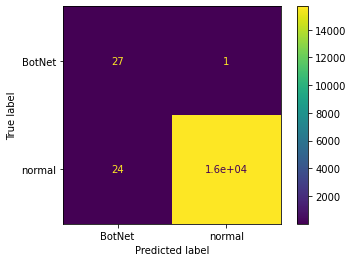

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

target_dict = {'BotNet' : 0,
               'normal' : 1}

disp = ConfusionMatrixDisplay(cm, target_dict)
disp.plot()

In [ ]:
mcm = multilabel_confusion_matrix(y_test, y_pred)
print(mcm)

[[[15685    24]
  [    1    27]]

 [[   27     1]
  [   24 15685]]]


In [ ]:
FP = cm.sum (axis = 0) - np.diag (cm) 
FN = cm.sum (axis = 1) - np.diag (cm) 
TP = np.diag (cm) 
TN = cm.sum () - (FP + FN + TP)

print('True positive: ', TP)
print('True negative: ', TN)
print('False positive: ', FP)
print('False negative: ', FN)

FP = FP.astype(float)
FN = FN.astype(float)
TP = TP.astype(float)
TN = TN.astype(float)

# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
# Specificity or true negative rate
TNR = TN/(TN+FP) 
# Fall out or false positive rate
FPR = FP/(FP+TN)
# False negative rate
FNR = FN/(TP+FN)

print('True positive rate: ', TPR)
print('True negative rate: ', TNR)
print('False positive rate: ', FPR)
print('False negative rate: ', FNR)

True positive:  [   27 15685]
True negative:  [15685    27]
False positive:  [24  1]
False negative:  [ 1 24]
True positive rate:  [0.96428571 0.99847221]
True negative rate:  [0.99847221 0.96428571]
False positive rate:  [0.00152779 0.03571429]
False negative rate:  [0.03571429 0.00152779]


In [ ]:
print(cm)

[[   27     1]
 [   24 15685]]


In [ ]:
print(report)

              precision    recall  f1-score   support

           0       0.53      0.96      0.68        28
           1       1.00      1.00      1.00     15709

    accuracy                           1.00     15737
   macro avg       0.76      0.98      0.84     15737
weighted avg       1.00      1.00      1.00     15737



In [ ]:
print('Accuracy: ', acc)
print('Precision_weighted: ', precision)
print('Recall_weighted: ', recall)
print('mcc: ', mcc)
print('f2: ', f2)

Accuracy:  0.9984113871767173
Precision_weighted:  0.9990990699076129
Recall_weighted:  0.9984113871767173
mcc:  0.7138865432115648
f2:  0.9985488479790328
